This notebook was created to run with kaggle GPU accelerator.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/songsheb/validation.csv
/kaggle/input/songsheb/train.csv
/kaggle/input/songsheb/test.csv


In [2]:
#install needed packages

!pip install transformers
!pip install wandb

In [4]:
#load Alephbert model

from transformers import BertModel, BertTokenizerFast, AutoModelForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained('onlplab/alephbert-base')

Downloading:   0%|          | 0.00/545k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/288 [00:00<?, ?B/s]

In [5]:
dataset = {
            "name": "Heb Songs",
            "train_path": "../input/songsheb/train.csv",
            "dev_path": "../input/songsheb/validation.csv",
            "test_path": "../input/songsheb/test.csv",
          }

def read_data():
    train = pd.read_csv(dataset['train_path'])
    dev = pd.read_csv(dataset['dev_path'])
    test = pd.read_csv(dataset['test_path'])
    return train, dev, test

train, dev, test = read_data()
train_encodings = tokenizer(train["content"].to_list(), truncation=True, padding=True)
dev_encodings = tokenizer(dev["content"].to_list(), truncation=True, padding=True)
test_encodings = tokenizer(test["content"].to_list(), truncation=True, padding=True)


In [6]:
import torch

class HebrewPoemsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [7]:
from pathlib import Path

sex_output_dir = Path("./results/sex/")
sex_output_dir.mkdir(parents=True, exist_ok=True)
heb_speaker_dir = Path("./results/heb_speaker/")
heb_speaker_dir.mkdir(parents=True, exist_ok=True)
birth_period_dir = Path("./results/birth_period/")
birth_period_dir.mkdir(parents=True, exist_ok=True)
death_period_dir = Path("./results/death_period/")
death_period_dir.mkdir(parents=True, exist_ok=True)
birth_israel_dir = Path("./results/birth_israel/")
birth_israel_dir.mkdir(parents=True, exist_ok=True)
death_israel_dir = Path("./results/death_israel/")
death_israel_dir.mkdir(parents=True, exist_ok=True)

In [55]:
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_multi_label_confusion(y_true, y_pred, labels_dict, output_dir: Path):
    mats = multilabel_confusion_matrix(y_true, y_pred)
    for i in range(len(mats)):
        ls = reversed(list(labels_dict[i]))
        disp = ConfusionMatrixDisplay(confusion_matrix=mats[i], display_labels=ls)
        disp.plot()
        plt.savefig(output_dir / f"{labels_dict[i][0]}_confusion_matrix.png")
        plt.show()

def plot_confusion(y_true, y_pred, labels, output_dir: Path):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=labels)
    disp.plot()
    plt.savefig(output_dir / "confusion_matrix.png")
    plt.show()

In [9]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns


def plot_multiclass_roc(y_test, y_score, labels, title, output_dir: Path, figsize=(17, 6)):
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    for i in range(len(labels)):
        binarize = np.vectorize(lambda x : 1 if x == i else 0)
        fpr[i], tpr[i], _ = roc_curve(binarize(y_test), binarize(y_score))
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{title} - ROC curve')
    for i in range(len(labels)):
        ax.plot(fpr[i], tpr[i], label=f"ROC curve (area = {roc_auc[i]:0.2f}) for {labels[i]}")
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.savefig(output_dir /f"{title}_roc_curve.png")
    plt.show()

def plot_binary_roc(y_test, y_pred, title, output_dir: Path):
    fpr, tpr, _ = roc_curve(y_test,  y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr,tpr,label=f"{title}, auc={auc}")
    plt.legend(loc=4)
    plt.title(f'{title} - ROC curve')
    plt.savefig(output_dir / f"{title}_roc_curve.png")
    plt.show()

In [10]:
from sklearn.metrics import precision_recall_fscore_support

def write_results_summary(y_true, y_pred, title, output_dir: Path):
    count_equals=0
    for a,b in zip(y_true, y_pred):
        if a==b:
            count_equals+=1
    scores = precision_recall_fscore_support(y_true, y_pred)
    output = f"classification of author {title}:\n" \
             f"accuracy={count_equals/len(y_pred)}\n" \
             f"precision={scores[0]}\n" \
             f"recall={scores[1]}\n" \
             f"fscore={scores[2]}\n" \
             f"support={scores[3]}\n"
    print(output)
    with open(output_dir / "summary.txt", 'w') as file:
        file.write(output)

In [11]:
from transformers import Trainer,TrainingArguments

# training arguments are the same for all categories
training_args = TrainingArguments(
    output_dir='/kaggle/working/results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10
)

## Author sex

In [74]:
train_labels=train["sex"].to_list()
dev_labels=dev["sex"].to_list()
test_labels=test["sex"].to_list()

train_dataset = HebrewPoemsDataset(train_encodings, train_labels)
dev_dataset = HebrewPoemsDataset(dev_encodings, dev_labels)
test_dataset = HebrewPoemsDataset(test_encodings, test_labels)

In [75]:
model = AutoModelForSequenceClassification.from_pretrained("onlplab/alephbert-base")
model.save_pretrained(sex_output_dir / "initial_pretrained")

Some weights of the model checkpoint at onlplab/alephbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base

In [76]:
!ls -latr /kaggle/working/results/sex/initial_pretrained

total 492200
drwxr-xr-x 2 root root      4096 Aug 15 08:33 .
drwxr-xr-x 3 root root      4096 Aug 15 08:49 ..
-rw-r--r-- 1 root root       624 Aug 15 10:46 config.json
-rw-r--r-- 1 root root 503998985 Aug 15 10:46 pytorch_model.bin


In [77]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset             # evaluation dataset
)

# train model
trainer.train()
trainer.save_model(sex_output_dir)

Step,Training Loss
10,0.729700
20,0.545200
30,0.297600
40,0.267700
50,0.134100
60,0.087800
70,0.219100
80,0.146400
90,0.181200
100,0.138200


In [78]:
!ls -latr ./results/sex/

total 492236
drwxr-xr-x 2 root root      4096 Aug 15 08:33 initial_pretrained
drwxr-xr-x 9 root root      4096 Aug 15 08:42 ..
-rw-r--r-- 1 root root       172 Aug 15 08:49 summary.txt
-rw-r--r-- 1 root root      7827 Aug 15 08:49 confusion_matrix.png
drwxr-xr-x 3 root root      4096 Aug 15 08:49 .
-rw-r--r-- 1 root root      8805 Aug 15 08:49 sex_roc_curve.png
-rw-r--r-- 1 root root       673 Aug 15 11:01 config.json
-rw-r--r-- 1 root root 504001801 Aug 15 11:01 pytorch_model.bin
-rw-r--r-- 1 root root      2415 Aug 15 11:01 training_args.bin


In [79]:
raw_pred, _, _ = trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

In [80]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

classification of author sex:
accuracy=0.9799809342230696
precision=[0.98609732 0.83333333]
recall=[0.993      0.71428571]
fscore=[0.98953662 0.76923077]
support=[1000   49]



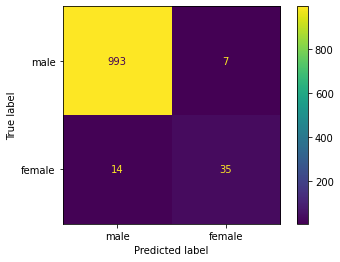

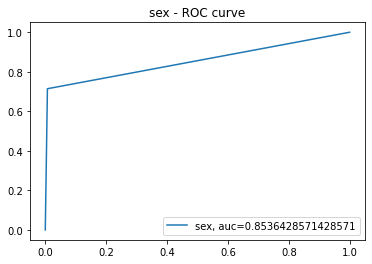

In [81]:
write_results_summary(test_dataset.labels, y_pred, "sex", sex_output_dir)
plot_confusion(test_dataset.labels, y_pred, ("male", "female"), sex_output_dir)
plot_binary_roc(test_dataset.labels, y_pred, "sex", sex_output_dir)

## Translated songs

In [20]:
train_labels=train["hebrew_speaker"].to_list()
dev_labels=dev["hebrew_speaker"].to_list()
test_labels=test["hebrew_speaker"].to_list()

train_dataset = HebrewPoemsDataset(train_encodings, train_labels)
dev_dataset = HebrewPoemsDataset(dev_encodings, dev_labels)
test_dataset = HebrewPoemsDataset(test_encodings, test_labels)

In [21]:
#load Alephbert model

model = AutoModelForSequenceClassification.from_pretrained("onlplab/alephbert-base")
model.save_pretrained(heb_speaker_dir / "initial_pretrained")

Some weights of the model checkpoint at onlplab/alephbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base

In [22]:
!ls -latr /kaggle/working/results/heb_speaker/initial_pretrained

total 492200
drwxr-xr-x 3 root root      4096 Aug 15 08:49 ..
-rw-r--r-- 1 root root       624 Aug 15 08:49 config.json
drwxr-xr-x 2 root root      4096 Aug 15 08:49 .
-rw-r--r-- 1 root root 503998985 Aug 15 08:49 pytorch_model.bin


In [23]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset             # evaluation dataset
)
# train model
trainer.train()
trainer.save_model(heb_speaker_dir)

Step,Training Loss
10,0.611700
20,0.450200
30,0.225900
40,0.143900
50,0.192500
60,0.239300
70,0.179400
80,0.240400
90,0.136200
100,0.194400


In [24]:
!ls -latr ./results/heb_speaker/

total 492212
drwxr-xr-x 9 root root      4096 Aug 15 08:42 ..
drwxr-xr-x 2 root root      4096 Aug 15 08:49 initial_pretrained
-rw-r--r-- 1 root root       673 Aug 15 09:04 config.json
-rw-r--r-- 1 root root 504001801 Aug 15 09:04 pytorch_model.bin
-rw-r--r-- 1 root root      2415 Aug 15 09:04 training_args.bin
drwxr-xr-x 3 root root      4096 Aug 15 09:04 .


In [25]:
raw_pred, _, _ = trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

In [26]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

classification of author hebrew_speaker:
accuracy=0.9714013346043852
precision=[0.65384615 0.97947214]
recall=[0.44736842 0.99109792]
fscore=[0.53125    0.98525074]
support=[  38 1011]



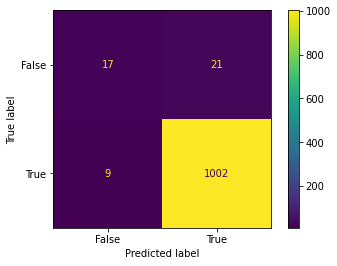

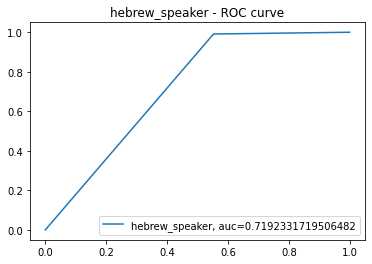

In [27]:
write_results_summary(test_dataset.labels, y_pred, "hebrew_speaker", heb_speaker_dir)
plot_confusion(test_dataset.labels, y_pred, ("False", "True"), heb_speaker_dir)
plot_binary_roc(test_dataset.labels, y_pred, "hebrew_speaker", heb_speaker_dir)

## Author birth time period

In [28]:
train_labels=train["birth_period"].to_list()
dev_labels=dev["birth_period"].to_list()
test_labels=test["birth_period"].to_list()

train_dataset = HebrewPoemsDataset(train_encodings, train_labels)
dev_dataset = HebrewPoemsDataset(dev_encodings, dev_labels)
test_dataset = HebrewPoemsDataset(test_encodings, test_labels)

In [29]:
#load Alephbert model

model = AutoModelForSequenceClassification.from_pretrained("onlplab/alephbert-base", num_labels=5)
model.save_pretrained(birth_period_dir / "initial_pretrained")

Some weights of the model checkpoint at onlplab/alephbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base

In [30]:
!ls -latr /kaggle/working/results/birth_period/initial_pretrained

total 492208
drwxr-xr-x 3 root root      4096 Aug 15 09:05 ..
-rw-r--r-- 1 root root       854 Aug 15 09:05 config.json
drwxr-xr-x 2 root root      4096 Aug 15 09:05 .
-rw-r--r-- 1 root root 504008201 Aug 15 09:05 pytorch_model.bin


In [31]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset             # evaluation dataset
)
# train model
trainer.train()
trainer.save_model(birth_period_dir)

Step,Training Loss
10,1.598100
20,1.495100
30,1.336000
40,1.200300
50,1.036400
60,0.938500
70,0.917500
80,0.759100
90,0.686300
100,0.643500


In [32]:
!ls -latr ./results/birth_period

total 492220
drwxr-xr-x 9 root root      4096 Aug 15 08:42 ..
drwxr-xr-x 2 root root      4096 Aug 15 09:05 initial_pretrained
-rw-r--r-- 1 root root       903 Aug 15 09:20 config.json
-rw-r--r-- 1 root root      2415 Aug 15 09:20 training_args.bin
-rw-r--r-- 1 root root 504011017 Aug 15 09:20 pytorch_model.bin
drwxr-xr-x 3 root root      4096 Aug 15 09:20 .


In [33]:
raw_pred, _, _ = trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

In [34]:
y_pred

array([1, 1, 3, ..., 3, 1, 1])

classification of author birth_period:
accuracy=0.9380362249761678
precision=[1.         0.97327394 0.7962963  0.9233871  0.91111111]
recall=[0.83333333 0.96681416 0.70491803 0.96016771 0.77358491]
fscore=[0.90909091 0.9700333  0.74782609 0.94141829 0.83673469]
support=[  6 452  61 477  53]



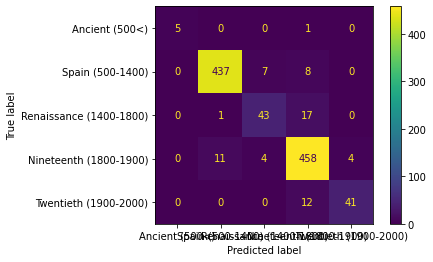

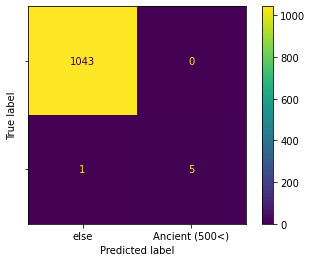

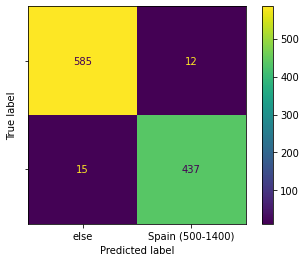

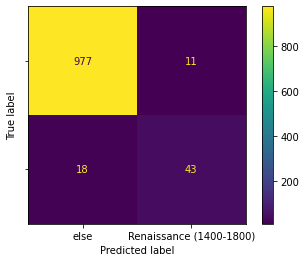

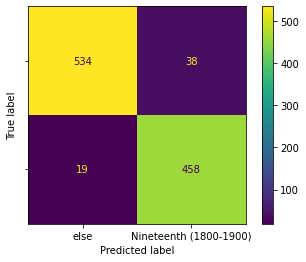

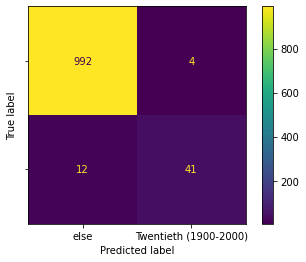

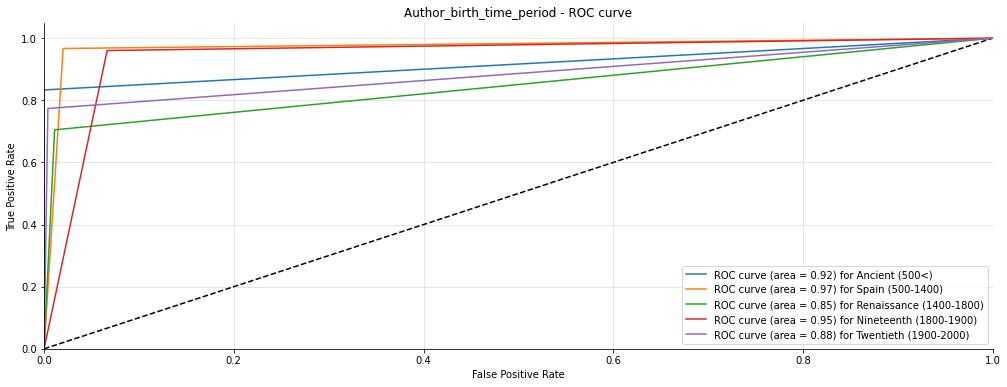

In [36]:
labels = ("Ancient (500<)", "Spain (500-1400)", "Renaissance (1400-1800)", "Nineteenth (1800-1900)", "Twentieth (1900-2000)")
labels_dict = {0: ("Ancient (500<)", "else"),
               1: ("Spain (500-1400)", "else"),
               2: ("Renaissance (1400-1800)", "else"),
               3: ("Nineteenth (1800-1900)", "else"),
               4: ("Twentieth (1900-2000)", "else")}
write_results_summary(test_dataset.labels, y_pred, "birth_period", birth_period_dir)
plot_confusion(test_dataset.labels, y_pred, labels, birth_period_dir)
plot_multi_label_confusion(test_dataset.labels, y_pred, labels_dict, birth_period_dir)
plot_multiclass_roc(test_dataset.labels, y_pred, labels, "Author_birth_time_period", birth_period_dir)

## Author death time period

In [66]:
train_labels=train["death_period"].to_list()
dev_labels=dev["death_period"].to_list()
test_labels=test["death_period"].to_list()

train_dataset = HebrewPoemsDataset(train_encodings, train_labels)
dev_dataset = HebrewPoemsDataset(dev_encodings, dev_labels)
test_dataset = HebrewPoemsDataset(test_encodings, test_labels)

In [67]:
#load Alephbert model

model = AutoModelForSequenceClassification.from_pretrained("onlplab/alephbert-base", num_labels=6)
model.save_pretrained(death_period_dir / "initial_pretrained")

Some weights of the model checkpoint at onlplab/alephbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base

In [68]:
!ls -latr /kaggle/working/results/death_period/initial_pretrained

total 492216
drwxr-xr-x 2 root root      4096 Aug 15 09:30 .
drwxr-xr-x 3 root root      4096 Aug 15 09:52 ..
-rw-r--r-- 1 root root       892 Aug 15 10:30 config.json
-rw-r--r-- 1 root root 504011273 Aug 15 10:30 pytorch_model.bin


In [69]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset             # evaluation dataset
)
# train model
trainer.train()
trainer.save_model(death_period_dir)

Step,Training Loss
10,1.877000
20,1.710000
30,1.541500
40,1.364100
50,1.188300
60,1.036800
70,0.889100
80,0.786900
90,0.767500
100,0.685700


In [70]:
!ls -latr ./results/death_period

total 492360
drwxr-xr-x 9 root root      4096 Aug 15 08:42  ..
drwxr-xr-x 2 root root      4096 Aug 15 09:30  initial_pretrained
-rw-r--r-- 1 root root     17737 Aug 15 09:52  confusion_matrix.png
-rw-r--r-- 1 root root      7881 Aug 15 09:52 'Ancient (500<)_confusion_matrix.png'
-rw-r--r-- 1 root root      8336 Aug 15 09:52 'Spain (500-1400)_confusion_matrix.png'
-rw-r--r-- 1 root root      8035 Aug 15 09:52 'Renaissance (1400-1800)_confusion_matrix.png'
-rw-r--r-- 1 root root      8161 Aug 15 09:52 'Nineteenth (1800-1900)_confusion_matrix.png'
-rw-r--r-- 1 root root      8462 Aug 15 09:52 'Twentieth (1900-2000)_confusion_matrix.png'
drwxr-xr-x 3 root root      4096 Aug 15 09:52  .
-rw-r--r-- 1 root root     65021 Aug 15 09:52  Author_death_time_period_roc_curve.png
-rw-r--r-- 1 root root       167 Aug 15 10:13  summary.txt
-rw-r--r-- 1 root root       941 Aug 15 10:46  config.json
-rw-r--r-- 1 root root 504014089 Aug 15 10:46  pytorch_model.bin
-rw-r--r-- 1 root root      2415 Aug 15

In [71]:
raw_pred, _, _ = trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

In [72]:
y_pred

array([1, 1, 4, ..., 4, 1, 1])

classification of author death_period:
accuracy=0.9275500476644424
precision=[1.         0.97355769 0.92063492 0.71666667 0.91485149]
recall=[0.83333333 0.96199525 0.81690141 0.5890411  0.9665272 ]
fscore=[0.90909091 0.96774194 0.86567164 0.64661654 0.93997965]
support=[  6 421  71  73 478]



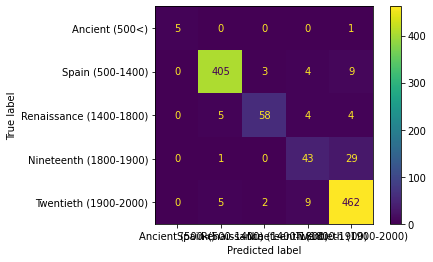

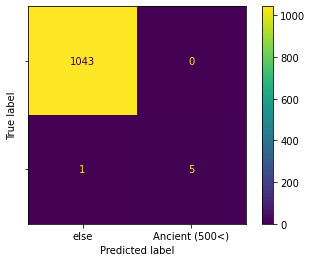

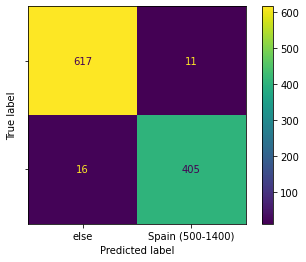

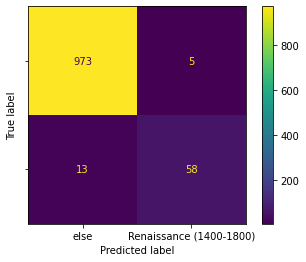

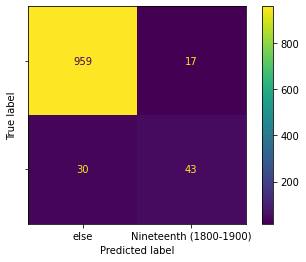

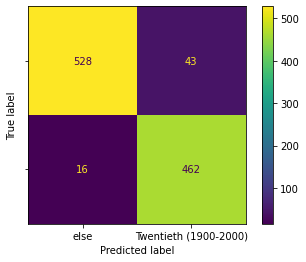

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


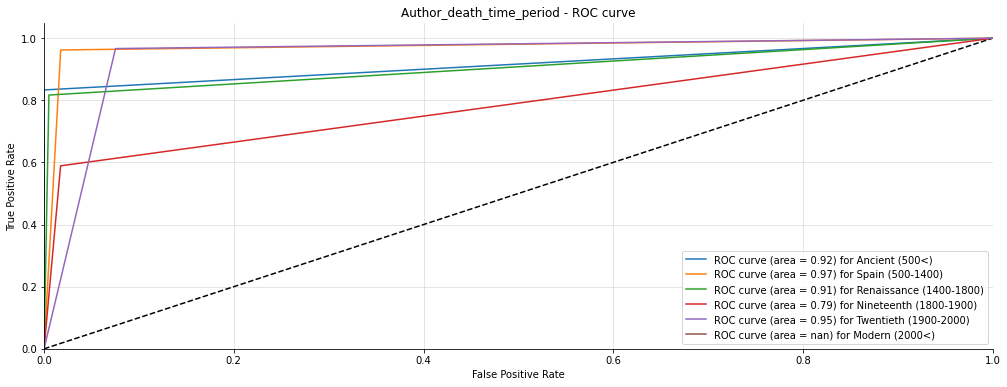

In [73]:
labels = ("Ancient (500<)", "Spain (500-1400)", "Renaissance (1400-1800)", "Nineteenth (1800-1900)", "Twentieth (1900-2000)", "Modern (2000<)")
labels_dict = {0: ("Ancient (500<)", "else"),
               1: ("Spain (500-1400)", "else"),
               2: ("Renaissance (1400-1800)", "else"),
               3: ("Nineteenth (1800-1900)", "else"),
               4: ("Twentieth (1900-2000)", "else"),
               5: ("Modern (2000<)", "else")}
write_results_summary(test_dataset.labels, y_pred, "death_period", death_period_dir)
plot_confusion(test_dataset.labels, y_pred, labels[:len(set(y_pred))], death_period_dir)
plot_multi_label_confusion(test_dataset.labels, y_pred, labels_dict, death_period_dir)
plot_multiclass_roc(test_dataset.labels, y_pred, labels, "Author_death_time_period", death_period_dir)

## Author born in Israel

In [47]:
train_labels=train["birth_place_israel"].to_list()
dev_labels=dev["birth_place_israel"].to_list()
test_labels=test["birth_place_israel"].to_list()

train_dataset = HebrewPoemsDataset(train_encodings, train_labels)
dev_dataset = HebrewPoemsDataset(dev_encodings, dev_labels)
test_dataset = HebrewPoemsDataset(test_encodings, test_labels)

In [48]:
#load Alephbert model

model = AutoModelForSequenceClassification.from_pretrained("onlplab/alephbert-base")
model.save_pretrained(birth_israel_dir / "initial_pretrained")

Some weights of the model checkpoint at onlplab/alephbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base

In [49]:
!ls -latr /kaggle/working/results/birth_israel/initial_pretrained

total 492200
drwxr-xr-x 3 root root      4096 Aug 15 09:53 ..
-rw-r--r-- 1 root root       624 Aug 15 09:53 config.json
drwxr-xr-x 2 root root      4096 Aug 15 09:53 .
-rw-r--r-- 1 root root 503998985 Aug 15 09:53 pytorch_model.bin


In [50]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset             # evaluation dataset
)
# train model
trainer.train()
trainer.save_model(birth_israel_dir)

Step,Training Loss
10,0.736400
20,0.520800
30,0.263600
40,0.103100
50,0.077000
60,0.009200
70,0.004800
80,0.077800
90,0.038000
100,0.003100


In [51]:
!ls -latr ./results/birth_israel

total 492212
drwxr-xr-x 9 root root      4096 Aug 15 08:42 ..
drwxr-xr-x 2 root root      4096 Aug 15 09:53 initial_pretrained
-rw-r--r-- 1 root root       673 Aug 15 10:08 config.json
-rw-r--r-- 1 root root      2415 Aug 15 10:08 training_args.bin
-rw-r--r-- 1 root root 504001801 Aug 15 10:08 pytorch_model.bin
drwxr-xr-x 3 root root      4096 Aug 15 10:08 .


In [52]:
raw_pred, _, _ = trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

In [53]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

classification of author born_in_israel:
accuracy=0.9923736892278361
precision=[0.99237369 0.        ]
recall=[1. 0.]
fscore=[0.99617225 0.        ]
support=[1041    8]



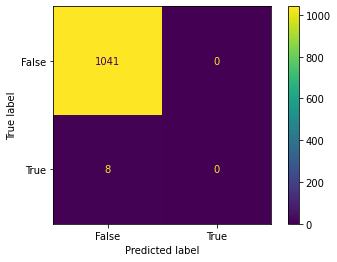

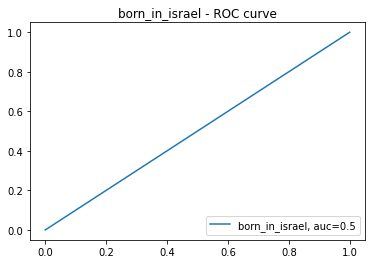

In [57]:
write_results_summary(test_dataset.labels, y_pred, "born_in_israel", birth_israel_dir)
plot_confusion(test_dataset.labels, y_pred, ("False", "True"), birth_israel_dir)
plot_binary_roc(test_dataset.labels, y_pred, "born_in_israel", birth_israel_dir)

## Author died in Israel

In [58]:
train_labels=train["death_place_israel"].to_list()
dev_labels=dev["death_place_israel"].to_list()
test_labels=test["death_place_israel"].to_list()

train_dataset = HebrewPoemsDataset(train_encodings, train_labels)
dev_dataset = HebrewPoemsDataset(dev_encodings, dev_labels)
test_dataset = HebrewPoemsDataset(test_encodings, test_labels)

In [59]:
#load Alephbert model

model = AutoModelForSequenceClassification.from_pretrained("onlplab/alephbert-base")
model.save_pretrained(death_israel_dir / "initial_pretrained")

Some weights of the model checkpoint at onlplab/alephbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base

In [60]:
!ls -latr /kaggle/working/results/death_israel/initial_pretrained

total 492200
drwxr-xr-x 3 root root      4096 Aug 15 10:14 ..
-rw-r--r-- 1 root root       624 Aug 15 10:14 config.json
drwxr-xr-x 2 root root      4096 Aug 15 10:14 .
-rw-r--r-- 1 root root 503998985 Aug 15 10:14 pytorch_model.bin


In [61]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset             # evaluation dataset
)
# train model
trainer.train()
trainer.save_model(death_israel_dir)

Step,Training Loss
10,0.709300
20,0.626300
30,0.552000
40,0.572200
50,0.631900
60,0.529900
70,0.560000
80,0.495800
90,0.491200
100,0.552800


In [62]:
!ls -latr ./results/death_israel/

total 492212
drwxr-xr-x 9 root root      4096 Aug 15 08:42 ..
drwxr-xr-x 2 root root      4096 Aug 15 10:14 initial_pretrained
-rw-r--r-- 1 root root       673 Aug 15 10:30 config.json
-rw-r--r-- 1 root root      2415 Aug 15 10:30 training_args.bin
-rw-r--r-- 1 root root 504001801 Aug 15 10:30 pytorch_model.bin
drwxr-xr-x 3 root root      4096 Aug 15 10:30 .


In [63]:
raw_pred, _, _ = trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

In [64]:
y_pred

array([0, 1, 0, ..., 1, 0, 0])

classification of author died_in_israel:
accuracy=0.8751191611058151
precision=[0.90247253 0.81308411]
recall=[0.91631799 0.78614458]
fscore=[0.90934256 0.79938744]
support=[717 332]



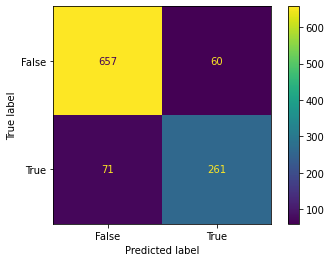

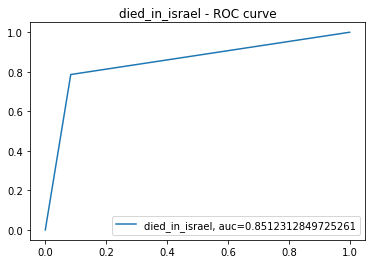

In [65]:
write_results_summary(test_dataset.labels, y_pred, "died_in_israel", death_israel_dir)
plot_confusion(test_dataset.labels, y_pred, ("False", "True"), death_israel_dir)
plot_binary_roc(test_dataset.labels, y_pred, "died_in_israel", death_israel_dir)

In [90]:
from IPython.display import FileLink, display
from glob import glob

result_dirs = [sex_output_dir, heb_speaker_dir, birth_period_dir, death_period_dir, 
    birth_israel_dir, death_israel_dir]
for dir_path in result_dirs:
    display(FileLink(str(dir_path / "summary.txt")))
    for i in glob(str(dir_path / "*.png")):
        display(FileLink(i))

/kaggle/working/results/sex/summary.txt

/kaggle/working/results/sex/confusion_matrix.png

/kaggle/working/results/sex/sex_roc_curve.png

/kaggle/working/results/heb_speaker/summary.txt

/kaggle/working/results/heb_speaker/hebrew_speaker_roc_curve.png

/kaggle/working/results/heb_speaker/confusion_matrix.png

/kaggle/working/results/birth_period/summary.txt

/kaggle/working/results/birth_period/Renaissance (1400-1800)_confusion_matrix.png

/kaggle/working/results/birth_period/Twentieth (1900-2000)_confusion_matrix.png

/kaggle/working/results/birth_period/Ancient (500<)_confusion_matrix.png

/kaggle/working/results/birth_period/Nineteenth (1800-1900)_confusion_matrix.png

/kaggle/working/results/birth_period/confusion_matrix.png

/kaggle/working/results/birth_period/Author_birth_time_period_roc_curve.png

/kaggle/working/results/birth_period/Spain (500-1400)_confusion_matrix.png

/kaggle/working/results/death_period/summary.txt

/kaggle/working/results/death_period/Renaissance (1400-1800)_confusion_matrix.png

/kaggle/working/results/death_period/Twentieth (1900-2000)_confusion_matrix.png

/kaggle/working/results/death_period/Ancient (500<)_confusion_matrix.png

/kaggle/working/results/death_period/Nineteenth (1800-1900)_confusion_matrix.png

/kaggle/working/results/death_period/confusion_matrix.png

/kaggle/working/results/death_period/Author_death_time_period_roc_curve.png

/kaggle/working/results/death_period/Spain (500-1400)_confusion_matrix.png

/kaggle/working/results/birth_israel/summary.txt

/kaggle/working/results/birth_israel/confusion_matrix.png

/kaggle/working/results/birth_israel/born_in_israel_roc_curve.png

/kaggle/working/results/death_israel/summary.txt

/kaggle/working/results/death_israel/confusion_matrix.png

/kaggle/working/results/death_israel/died_in_israel_roc_curve.png